**Load the HDF5 File**

In [1]:
import os
import time
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch.utils.data import random_split
from torch_geometric.loader import DataLoader
from pc_dataset import H5PCDataset
import torch_geometric.transforms as T
from torch.utils.data import Dataset,Subset
from torch_geometric.data import Data
from torchmetrics import JaccardIndex

In [2]:
torch.cuda.empty_cache()

In [3]:
# File path to the hdf5 dataset
#script_dir = os.path.dirname(os.getcwd())
#hdf5_file_path= os.path.join(script_dir, '.', 'docs', 'sim_pc_dataset.h5')
hdf5_file_path= "../docs/sim_pc_dataset_moved.h5"

# take out colors
class SelectLast3Features:
    def __call__(self, data):
        # If data.x is defined, select only its last 3 features.
        if data.x is not None:
            data.x = data.x[:, -3:]
        return data

# transform and pre_transform
transform = T.Compose([
    T.RandomJitter(0.01),
    T.RandomRotate(15, axis=0),
    T.RandomRotate(15, axis=1),
    T.RandomRotate(15, axis=2)
    ])

pre_transform =  T.Compose([
    #T.NormalizeScale(),
    SelectLast3Features()
    ])

# Create the dataset
full_dataset = H5PCDataset(hdf5_file_path, pre_transform = pre_transform)

# Define split sizes (e.g., 80% training and 20% validation)
total_size = len(full_dataset)
train_size = int(0.8 * total_size)
test_size = total_size - train_size

# Randomly split the dataset
train_subset, test_subset = random_split(full_dataset, [train_size, test_size])

In [4]:
#Wrap train_subset in AugmentedSubset
class AugmentedSubset(Subset):
    def __init__(self, subset, transform):
        super().__init__(subset.dataset, subset.indices)
        self.transform = transform

    def __getitem__(self, idx):
        data = super().__getitem__(idx)
        return self.transform(data)

train_dataset = AugmentedSubset(train_subset, transform)
test_dataset = test_subset 

In [5]:
print(train_dataset[0])
print(train_dataset.dataset.num_classes)
print(test_dataset[0])
print(test_dataset.dataset.num_classes)

Data(x=[4096, 3], y=[4096], pos=[4096, 3])
13
Data(x=[4096, 3], y=[4096], pos=[4096, 3])
13


In [6]:
batch_size=32
num_workers=0

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,
                          num_workers=num_workers)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False,
                         num_workers=num_workers)

**Training with Simulated Point Cloud**

In [7]:
import torch
import torch.nn.functional as F
import torch_geometric.transforms as T
from torch_geometric.typing import WITH_TORCH_CLUSTER

from pyg_pointnet2 import PyGPointNet2NoColor

if not WITH_TORCH_CLUSTER:
    quit("This example requires 'torch-cluster'")

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = PyGPointNet2NoColor(num_classes=13).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

"""
def train():
    model.train()

    total_loss = correct_nodes = total_nodes = 0
    for i, data in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data)
        loss = F.nll_loss(out, data.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        correct_nodes += out.argmax(dim=1).eq(data.y).sum().item()
        total_nodes += data.num_nodes

        if (i + 1) % 10 == 0:
            print(f'[{i+1}/{len(train_loader)}] Loss: {total_loss / 10:.4f} '
                  f'Train Acc: {correct_nodes / total_nodes:.4f}')
            total_loss = correct_nodes = total_nodes = 0
"""


"\ndef train():\n    model.train()\n\n    total_loss = correct_nodes = total_nodes = 0\n    for i, data in enumerate(train_loader):\n        data = data.to(device)\n        optimizer.zero_grad()\n        out = model(data)\n        loss = F.nll_loss(out, data.y)\n        loss.backward()\n        optimizer.step()\n        total_loss += loss.item()\n        correct_nodes += out.argmax(dim=1).eq(data.y).sum().item()\n        total_nodes += data.num_nodes\n\n        if (i + 1) % 10 == 0:\n            print(f'[{i+1}/{len(train_loader)}] Loss: {total_loss / 10:.4f} '\n                  f'Train Acc: {correct_nodes / total_nodes:.4f}')\n            total_loss = correct_nodes = total_nodes = 0\n"

In [9]:
def train_one_epoch():
    model.train()
    running_loss = correct = total = 0

    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data)
        loss = F.nll_loss(out, data.y)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        correct      += out.argmax(1).eq(data.y).sum().item()
        total        += data.num_nodes

    # Average loss & accuracy for this epoch
    epoch_loss = running_loss / len(train_loader) 
    epoch_acc  = correct / total

    return epoch_loss, epoch_acc

In [10]:

@torch.no_grad()
def test(loader):
    model.eval()
    jaccard = JaccardIndex(num_classes=loader.dataset.dataset.num_classes, task="multiclass").to(device)
    
    for data in loader:
        data = data.to(device)
        outs = model(data)
        preds = outs.argmax(dim=-1)
        jaccard.update(preds, data.y)
    
    return jaccard.compute().item()

In [11]:
# Record history metrics
loss_history   = []
acc_history    = []
iou_history    = []
time_history   = []

In [12]:
for epoch in range(1, 51):
    # Track epoch start time
    start_time = time.perf_counter()
    #train()

    loss, acc = train_one_epoch()
    loss_history.append(loss)
    acc_history.append(acc)

    iou = test(test_loader)
    iou_history.append(iou)

    # Calculate epoch duration
    epoch_time = time.perf_counter() - start_time
    time_history.append(epoch_time)
    
    # Print results with time
    print(f"Epoch {epoch:02d} | "
          f"Loss: {loss:.4f} | "
          f"Acc: {acc:.4f} | "
          f"IoU: {iou:.4f} | "
          f"Time: {epoch_time:.2f}s")

Epoch 01 | Loss: 2.1077 | Acc: 0.4030 | IoU: 0.0348 | Time: 15.73s
Epoch 02 | Loss: 1.2900 | Acc: 0.6062 | IoU: 0.0966 | Time: 3.40s
Epoch 03 | Loss: 1.1849 | Acc: 0.6704 | IoU: 0.1414 | Time: 3.29s
Epoch 04 | Loss: 1.0444 | Acc: 0.7046 | IoU: 0.1853 | Time: 3.30s
Epoch 05 | Loss: 1.0262 | Acc: 0.7206 | IoU: 0.1915 | Time: 3.41s
Epoch 06 | Loss: 0.9844 | Acc: 0.7334 | IoU: 0.1998 | Time: 3.44s
Epoch 07 | Loss: 0.9234 | Acc: 0.7447 | IoU: 0.2093 | Time: 3.34s
Epoch 08 | Loss: 0.9306 | Acc: 0.7568 | IoU: 0.2108 | Time: 3.35s
Epoch 09 | Loss: 0.8784 | Acc: 0.7522 | IoU: 0.2123 | Time: 3.35s
Epoch 10 | Loss: 0.7971 | Acc: 0.7704 | IoU: 0.1854 | Time: 3.36s
Epoch 11 | Loss: 0.8094 | Acc: 0.7666 | IoU: 0.2029 | Time: 3.36s
Epoch 12 | Loss: 0.7273 | Acc: 0.7834 | IoU: 0.2277 | Time: 3.37s
Epoch 13 | Loss: 0.7481 | Acc: 0.7913 | IoU: 0.2358 | Time: 3.36s
Epoch 14 | Loss: 0.7270 | Acc: 0.7810 | IoU: 0.2333 | Time: 3.36s
Epoch 15 | Loss: 0.7205 | Acc: 0.7888 | IoU: 0.2373 | Time: 3.39s
Epoch 16 

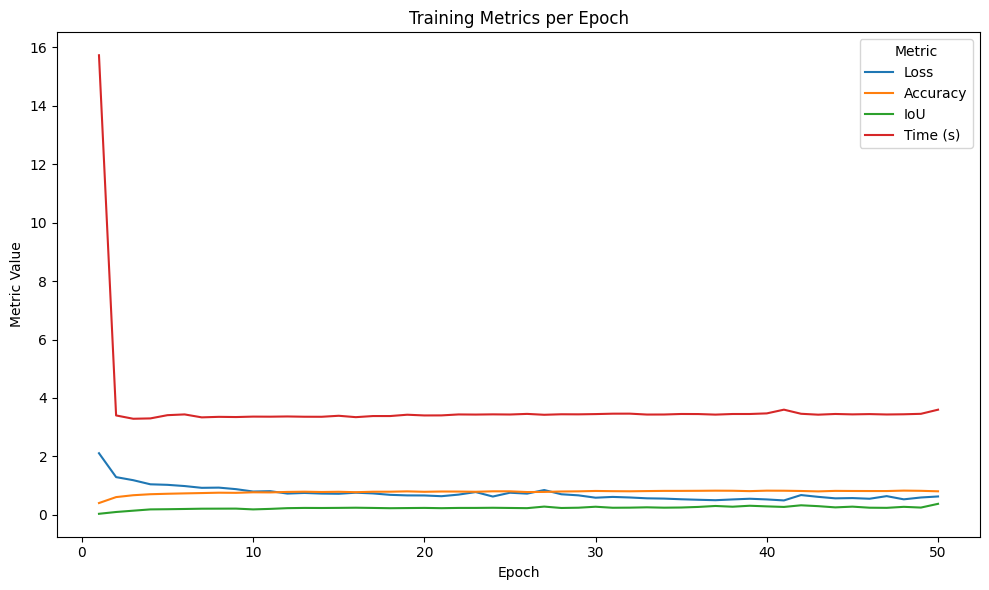

In [17]:
# Visualize with seaborn

# 1) Build DataFrame
df = pd.DataFrame({
    'epoch': range(1, len(loss_history) + 1),
    'Loss': loss_history,
    'Accuracy': acc_history,
    'IoU': iou_history,
    'Time (s)': time_history
})

# 2) Melt to long form for seaborn
df_long = df.melt(id_vars='epoch',
                  var_name='Metric',
                  value_name='Value')

# 3) Plot all metrics in one figure
plt.figure(figsize=(10, 6))
sns.lineplot(data=df_long, x='epoch', y='Value', hue='Metric')  
plt.title('Training Metrics per Epoch')  
plt.xlabel('Epoch')  
plt.ylabel('Metric Value')  
plt.legend(title='Metric', loc='best')
plt.tight_layout()
plt.show()

In [18]:
# Export without the index column
df.to_csv("../docs/sim_train_metrics.csv", index=False)

In [19]:
sim_checkpoint_path= 'checkpoints/pointnet2_smartlab_sim_transform_seg_x3_50_checkpoint.pth'

# Save model, optimizer state, and any other info needed
torch.save({
    'epoch': 100,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    #'loss': loss,
    #'test_accuracy': test_acc
}, sim_checkpoint_path)

print("Checkpoint saved successfully!")

Checkpoint saved successfully!
